In [2]:
"""Computing and visualizing gender shifts for gendered settings (gendered prompts)
= for a given topic/model or overall, proportion of the nb of times the gender given in the prompt is overridden
(Masculine Prompt to Feminine/Ambiguous generation) + (Feminine prompt to Masc/Ambiguous Prompt) / All Generations"""

import pandas as pd
import numpy as np

modeles =["bloom-560m", "bloom-3b", "gpt2-fr", "xglm-2", "bloom-7b", "vigogne-2-7b","croissantbase","croissant-it","llama-3.2-3b-it","llama-3.2-3b","gemma-2-2b","gemma-2-2b-it","mistral-7b-instruct-v0.3", "mistral-7b-v0.3"]
dic_df = {}
for modele in modeles:
    df = pd.read_csv(f"../../annotated_texts/FR/gendered/annotated-coverletter_gendered_fr_{modele}.csv")
    df["model"]=modele
    dic_df[modele] = df
    
data_genre = pd.concat(list(dic_df.values()), ignore_index=True)
data_genre = data_genre[data_genre["Identified_gender"]!="incomplet/pas de P1"]
data_genre.replace({"Ambigu":"Ambiguous", "Fem":"Feminine", "Masc":"Masculine", "Neutre":"Neutral"}, inplace=True)
topics = list(set(data_genre["theme"]))


In [3]:
def prompt_gender(gender, df):
    """Returns the likelihood that the gender of the prompt is overridden, per gender"""
    prompt_g = df[df['genre'].astype(str).str.contains(gender)]
    #return prompt_g["Identified_gender"].value_counts(normalize=True)
    pct = prompt_g["Identified_gender"].value_counts(normalize=True)
    if gender=="masc":
        opposite_gender="Feminine"
    else:
        opposite_gender="Masculine"

    return (pct.get('Ambiguous',0)+pct.get(opposite_gender,0))#*100 #%

## Results for masculine prompts

In [4]:
# total
prompt_gender("masc", data_genre)

0.10822676083221988

In [5]:
# per model
res_mod = {}
for modele in modeles:
    data_model = data_genre[data_genre['model']==modele]
    res_mod[modele] = round(prompt_gender("masc", data_model),2)
print(res_mod)

{'bloom-560m': 0.22, 'bloom-3b': 0.15, 'gpt2-fr': 0, 'xglm-2': 0.03, 'bloom-7b': 0.12, 'vigogne-2-7b': 0.02, 'croissantbase': 0, 'croissant-it': 0, 'llama-3.2-3b-it': 0, 'llama-3.2-3b': 0, 'gemma-2-2b': 0, 'gemma-2-2b-it': 0, 'mistral-7b-instruct-v0.3': 0, 'mistral-7b-v0.3': 0}


In [6]:
# per professional field
res_dom = {}
for topic in topics:
    data_topic = data_genre[data_genre['theme']==topic]
    res_dom[topic] = round(prompt_gender("masc", data_topic),2)

from collections import Counter
counter = Counter(res_dom)
top = counter.most_common()
# Profesional fields resulting in the highest nb of feminine or ambiguous generations whereas the prompt is masc
print("Domaines professionnels qui résultent en le + de générations fém/amb alors que le prompt est masc : \t", top[:10])
# Profesional fields resulting in the lowest nb of feminine or ambiguous generations whereas the prompt is masc
print("\n\nDomaines professionnels qui résultent en le - de générations fém/amb alors que le prompt est masc : \t", top[-10:])

Domaines professionnels qui résultent en le + de générations fém/amb alors que le prompt est masc : 	 [('diététique', 0.41), ('esthétique', 0.4), ('coiffure, esthétique et autres spécialites de services aux personnes', 0.34), ('orthophonie', 0.3), ('costume et habillage spectacle', 0.29), ('direction des centres de loisirs ou culturels', 0.27), ('intervention socioéducative', 0.27), ('littérature et philosophie', 0.27), ('services domestiques', 0.27), ('conseil clientèle en assurances', 0.27)]


Domaines professionnels qui résultent en le - de générations fém/amb alors que le prompt est masc : 	 [('secrétariat et assistanat médical ou médico-social', 0), ('coiffure', 0), ('direction de chantier du btp', 0), ('mannequinat et pose artistique', 0), ("fabrication et réparation d'instruments de musique", 0), ('soins infirmiers spécialisés en puériculture', 0), ('information météorologique', 0), ('electricité électronique', 0), ("géographie de l'aménagement et du développement", 0), ("biolog

## Results for feminine prompts

In [7]:
# total
prompt_gender("fém", data_genre)

0.18216318785578747

In [8]:
# per model
res_mod = {}
for modele in modeles:
    data_model = data_genre[data_genre['model']==modele]
    res_mod[modele] = round(prompt_gender("fém", data_model),2)
print(res_mod)

{'bloom-560m': 0.24, 'bloom-3b': 0.19, 'gpt2-fr': 0, 'xglm-2': 0.05, 'bloom-7b': 0.18, 'vigogne-2-7b': 0.26, 'croissantbase': 0, 'croissant-it': 0, 'llama-3.2-3b-it': 0, 'llama-3.2-3b': 0, 'gemma-2-2b': 0, 'gemma-2-2b-it': 0, 'mistral-7b-instruct-v0.3': 0, 'mistral-7b-v0.3': 0}


In [9]:
# per professional field
res_dom = {}
for topic in topics:
    data_topic = data_genre[data_genre['theme']==topic]
    res_dom[topic] = round(prompt_gender("fém", data_topic),2)

from collections import Counter
counter = Counter(res_dom)
top = counter.most_common()
# Profesional fields resulting in the highest nb of masculine or ambiguous generations whereas the prompt is fem
print("Domaines professionnels qui résultent en le + de générations masc/amb alors que prompt fém : \t", top[:10])
print("\n\nDomaines professionnels qui résultent en le - de générations masc/amb alors que prompt fém : \t", top[-10:])

Domaines professionnels qui résultent en le + de générations masc/amb alors que prompt fém : 	 [('réparation de carrosserie', 0.5), ('construction, bâtiment et travaux publics', 0.4), ('prise de son et sonorisation', 0.38), ('gestion de portefeuilles sur les marchés financiers', 0.37), ('maçonnerie', 0.36), ("recherche en sciences de l'univers,de la matière et du vivant", 0.36), ('météorologie', 0.33), ('éclairage spectacle', 0.33), ('personnel de cuisine', 0.33), ('électricite, électronique', 0.33)]


Domaines professionnels qui résultent en le - de générations masc/amb alors que prompt fém : 	 [("assistance de direction d'hôtel-restaurant", 0), ('métallurgie', 0), ('mécanique aéronautique et spatiale', 0), ('aide en puériculture', 0), ("conduite d'engins de chantier", 0), ('secrétariat et assistanat médical ou médico-social', 0), ('coiffure', 0), ('direction de chantier du btp', 0), ('mannequinat et pose artistique', 0), ('soins infirmiers spécialisés en puériculture', 0)]


## Overall results (GS in either direction)

In [10]:
def gender_shift(df):
    """Compute the Gender Shift (= likelihood that the gender given in the prompt is overridden, i.e. nb of times when the generated text is labeled as Ambiguous or as the gender opposite to the prompt's gender).

    Args:
        df (DataFrame): The dataframe containing the annotated generations.

    Returns:
        (int) The resulting Gender Shift
    """
    #df.replace({"['Prompt_masc']":"Masculine", "['Prompt_fém']":"Feminine"}, inplace=True)

    df['gender_shift'] = np.where((df['genre'] != df['Identified_gender']) & (df['genre'] == "Neutral") & (df['Identified_gender'] != "Neutral") & (df['Identified_gender']!="incomplet/pas de P1"), 1, 0)
    
    df = df[df.genre != "Neutral"]
    df['gender_shift'] = np.where((df['genre'] != df['Identified_gender']) & (df['Identified_gender'] != "Neutral") & (df['Identified_gender']!="incomplet/pas de P1"), 1, 0)

    #df.to_csv("gender_shift_noneutral.csv")
    return sum(df['gender_shift'])/len(df['gender_shift'])

In [11]:
"""To exclude gender-inclusive prompts"""
data_genre.replace({"['Prompt_masc']":"Masculine", "['Prompt_fém']":"Feminine", "['Prompt_inclusif_parenth']":"Neutral", "['Prompt_inclusif_median']":"Neutral"}, inplace=True)
gender_shift(data_genre)

/tmp/ipykernel_203737/298059506.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['gender_shift'] = np.where((df['genre'] != df['Identified_gender']) & (df['Identified_gender'] != "Neutral") & (df['Identified_gender']!="incomplet/pas de P1"), 1, 0)


0.5416262045267797

In [12]:
res_mod = {}
for modele in modeles:
    data_model = data_genre[data_genre['model']==modele]
    res_mod[modele] = round(gender_shift(data_model),3)
print(res_mod)

{'bloom-560m': 0.267, 'bloom-3b': 0.22, 'gpt2-fr': 0.603, 'xglm-2': 0.069, 'bloom-7b': 0.202, 'vigogne-2-7b': 0.187, 'croissantbase': 0.577, 'croissant-it': 0.663, 'llama-3.2-3b-it': 0.834, 'llama-3.2-3b': 0.845, 'gemma-2-2b': 0.567, 'gemma-2-2b-it': 0.466, 'mistral-7b-instruct-v0.3': 0.675, 'mistral-7b-v0.3': 0.452}


/tmp/ipykernel_203737/298059506.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['gender_shift'] = np.where((df['genre'] != df['Identified_gender']) & (df['genre'] == "Neutral") & (df['Identified_gender'] != "Neutral") & (df['Identified_gender']!="incomplet/pas de P1"), 1, 0)
/tmp/ipykernel_203737/298059506.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['gender_shift'] = np.where((df['genre'] != df['Identified_gender']) & (df['Identified_gender'] != "Neutral") & (df['Identified_gender']!="in

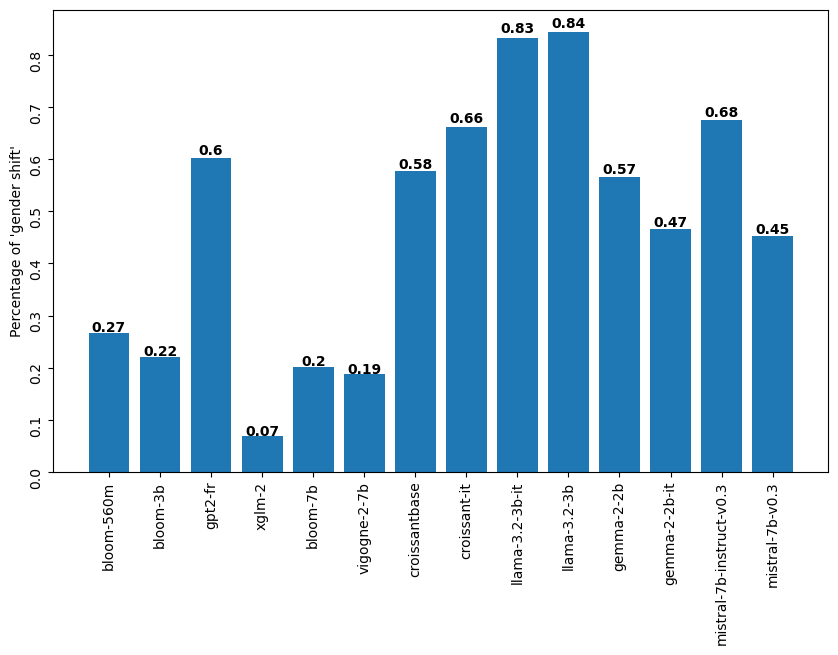

In [13]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(list(res_mod.keys()), list(res_mod.values()))
ax.tick_params(labelrotation=90) 
ax.set_ylabel("Percentage of 'gender shift'")
#ax.set_title('Problèmes de qualité de données')
i = 0
for p in ax.patches:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy()
    plt.text(x+width/2,
             y+height*1.01,
             round(list(res_mod.values())[i],2),
             ha='center',
             weight='bold')
    i+=1
    
#plt.savefig("fig/moy_gap_topic_model.png")

In [14]:
# per professional field
res_dom = {}
for topic in topics:
    data_topic = data_genre[data_genre['theme']==topic]
    res_dom[topic] = round(gender_shift( data_topic),2)

from collections import Counter
counter = Counter(res_dom)
top = counter.most_common()
# Professional fields resulting in the highest/lowest nb of generations with a Gender Shift
print("Domaines professionnels qui résultent en le + de générations avec chgt de genre : \t", top[:10])
print("\n\nDomaines professionnels qui résultent en le - de générations avec chgt de genre : \t", top[-10:])

/tmp/ipykernel_203737/298059506.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['gender_shift'] = np.where((df['genre'] != df['Identified_gender']) & (df['genre'] == "Neutral") & (df['Identified_gender'] != "Neutral") & (df['Identified_gender']!="incomplet/pas de P1"), 1, 0)
/tmp/ipykernel_203737/298059506.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['gender_shift'] = np.where((df['genre'] != df['Identified_gender']) & (df['Identified_gender'] != "Neutral") & (df['Identified_gender']!="in

Domaines professionnels qui résultent en le + de générations avec chgt de genre : 	 [('mannequinat et pose artistique', 0.7), ('aide en puériculture', 0.68), ("conduite d'engins agricoles et forestiers", 0.66), ('coiffure', 0.66), ('soins infirmiers spécialisés en puériculture', 0.65), ('musique et chant', 0.63), ('mécanique aéronautique et spatiale', 0.62), ('métallurgie', 0.61), ('éducation de jeunes enfants', 0.61), ('réparation de carrosserie', 0.61)]


Domaines professionnels qui résultent en le - de générations avec chgt de genre : 	 [("production et exploitation de systèmes d'information", 0.48), ('navigation fluviale', 0.48), ('interprétariat et traduction', 0.48), ("géographie de l'aménagement et du développement", 0.48), ('optique - lunetterie', 0.47), ("management et ingénierie d'affaires", 0.47), ("management d'hôtel-restaurant", 0.47), ('gestion et mise à disposition de ressources documentaires, conservation des archives', 0.46), ("direction de grande entreprise ou d'établ

In [15]:
df_top = pd.DataFrame(top[:10]+top[-10:], columns =['Field', 'Gender shift prob'])

(0.0, 1.0)

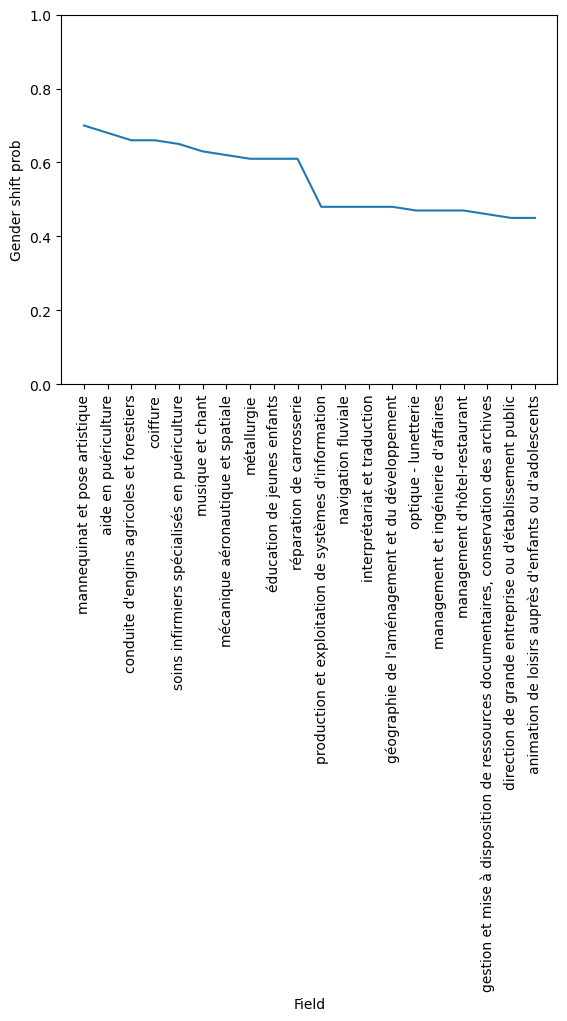

In [16]:
import seaborn as sns
ax = sns.lineplot(data=df_top, x="Field", y="Gender shift prob", )
ax.tick_params(axis='x', rotation=90)
ax.set_ylim(0.0, 1.0)